1合并流量文件

In [18]:
import pandas as pd
import os
import geopandas as gpd



# 拼接文件
df_all = pd.DataFrame(index=range(10212))

dir = "E:/Amap/processdata/count0704/2022/volume"
csv_files = os.listdir(dir)
for file in csv_files:
    # 提取文件名
    # print(file)
    new_df = pd.read_csv(dir+'/'+file, header=0, index_col=0)
    df_all = pd.concat([df_all, new_df], axis=1)
print('拼接完成')


# 处理拼接后文件
df_all['Sum2022'] = df_all.sum(axis=1)

df_all.reset_index(inplace=True)
df_all=df_all[['Sum2022','index']]

#改变索引
df_all.rename(columns={'index': 'FID2'}, inplace=True)
gdf = gpd.read_file("E:/Amap/processdata/result/Am17toAm19.shp")

df_all['FID2'] = df_all['FID2'].astype('int64')
print(df_all.shape)
gdf['FID2'] = gdf['FID2'].astype('int64')

merged_df = pd.merge(gdf, df_all, on='FID2')
merged_df['ave2022']=(merged_df['Sum2022']/354).astype('int64')

merged_df.to_file('E:/Amap/processdata/result/Am7toPm22.shp', 'ESRI Shapefile',encoding='utf-8')




拼接完成
(10212, 2)


In [28]:
import pandas as pd
import os
import geopandas as gpd

gpsdf=pd.read_csv('D:/Amap/huaweidata/8am_sort_osm50_march.csv')
gpsdf.sort_values(by='mroad',inplace=True)

osmid_df=pd.read_csv('D:/Amap/huaweidata/8am_sort_osm_idnew_minscope_meanV.csv')
osmid_df.rename(columns={'fid_1':'mroad'},inplace=True)

merged_df = pd.merge(gpsdf, osmid_df, on='mroad', how='left')  
merged_df.to_csv('D:/Amap/huaweidata/8am_sort_osm_idnew.csv')
pd.options.display.float_format = '{:.0f} '.format
count_df=merged_df.groupby('idnew')[['mroad']].count().reset_index()
count_df.rename(columns={'mroad':'count'},inplace=True)
count_df['meanVolume']=(count_df['count']/12).astype('int')
count_df.to_csv('D:/Amap/huaweidata/8am_sort_osm_idnew_minscope.csv')

In [29]:
count_df

,idnew,count,meanVolume
0,429,279,23
1,431,97,8
2,432,1059,88
3,433,4755,396
4,434,184,15
...,...,...,...
5525,1199464419,45,3
5526,1207080010,221,18
5527,1207080018,239,19
5528,1207080019,870,72


2路网流量统计

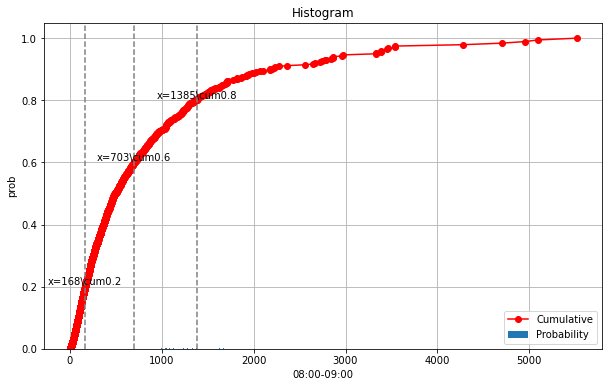

x值： [168, 703, 1385]


In [33]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import norm


def calplot(df,avecolname,startTime,endTime):
    '''
    roaddf=roaddf.sort_values(by=[avecolname])
    groupdf=roaddf.groupby(by=[avecolname]).count().reset_index()[[avecolname, 'FID2']]
    groupdf.columns = [avecolname, 'count']
    '''
    groupdf=df.sort_values(by=avecolname)
    sumnum=groupdf[avecolname].sum()
    groupdf['prob']=round(groupdf[avecolname]/sumnum,8)


    # 绘制直方图
    plt.figure(figsize=(10, 6))
    plt.bar(groupdf[avecolname], groupdf['prob'], width=1, align='center', alpha=1, label='Probability')

    hour1=startTime
    hour2=endTime

    plt.xlabel(f'{hour1}:00-{hour2}:00')
    plt.ylabel('prob')
    plt.title('Histogram')
    plt.grid(True)

    # 添加累计曲线
    cumulative_prob = groupdf['prob'].cumsum()
    plt.plot(groupdf[avecolname], cumulative_prob, color='r', marker='o', label='Cumulative')

    # 绘制竖虚线并获取x值

    target_prob = [0.2,0.6, 0.8]
    target_x = []
    for prob in target_prob:
        x = groupdf.loc[cumulative_prob >= prob, avecolname].iloc[0]
        target_x.append(x)
        plt.axvline(x, color='gray', linestyle='--')
        plt.text(x, prob, f'x={x}\cum{prob}', verticalalignment='bottom', horizontalalignment='center')


    # 显示图例
    plt.legend()

    # 显示图形
    plt.show()

    # 输出x值
    print("x值：", target_x)

df=pd.read_csv('D:/Amap/huaweidata/8am_sort_osm_idnew_minscope.csv')
avecolname='meanVolume'
startTime='08'
endTime='09'
calplot(df,avecolname,startTime,endTime)

In [91]:
gdf = gpd.read_file("E:/Amap/processdata/result/Am7toPm22.shp")
gdf['FC']=gdf['FC'].astype('float')

#第三等级
namedf3=gdf[(gdf['flagall']!=1)]
namelist3=namedf3['NAME_CHN'].unique()
namelist3 = pd.Series(namelist3).dropna().tolist()
gdf['setclass2'] = gdf['NAME_CHN'].str.contains('|'.join(namelist3), na=False)
gdf['finalclass'] = np.where(gdf['setclass2'],3, 0)

#第二等级
namedf2=gdf[(gdf['flagall']==1)&(gdf['FC']>=5)]
namelist2=namedf2['NAME_CHN'].unique()
namelist2 = pd.Series(namelist2).dropna().tolist()
gdf['setclass'] = gdf['NAME_CHN'].str.contains('|'.join(namelist2), na=False)
gdf['finalclass'] = gdf['finalclass'].where(~gdf['setclass'], 2)

#第一等级
namedf=gdf[(gdf['flagall']==1)&(gdf['FC']<5)]
namelist=namedf['NAME_CHN'].unique()
namelist = pd.Series(namelist).dropna().tolist()
gdf['setclass'] = gdf['NAME_CHN'].str.contains('|'.join(namelist), na=False)
gdf['finalclass'] = gdf['finalclass'].where(~gdf['setclass'], 1)


gdf.to_file('E:/Amap/processdata/result/class2.shp', 'ESRI Shapefile',encoding='utf-8')